In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
import missingno as msno
from semopy import Model, calc_stats , semplot
from graphviz import Digraph




Columns in the dataset:
['EXP_RAT_NUM', 'EXP', 'PSS', 'olderimale', 'olderi', 'Juvenailemale', 'Juvenaile', 'femaleolderi', 'femaleJuvenaile', 'femaleyoung', 'inactive', 'HFD', 'FD', 'LEW', 'EBR', 'MBR', 'PBR', 'ANX_i', 'STR', 'FREAZING', 'female', 'active']

Sample of Raw Data:
   EXP_RAT_NUM                          EXP  PSS  olderimale  olderi  \
0            1  PSS - male -Young - 3 Month    1           0       0   
1            2  PSS - male -Young - 3 Month    1           0       0   
2            3  PSS - male -Young - 3 Month    1           0       0   
3            4  PSS - male -Young - 3 Month    1           0       0   
4            5  PSS - male -Young - 3 Month    1           0       0   

   Juvenailemale  Juvenaile  femaleolderi  femaleJuvenaile  femaleyoung  ...  \
0              0          0             0                0            0  ...   
1              0          0             0                0            0  ...   
2              0          0             0      

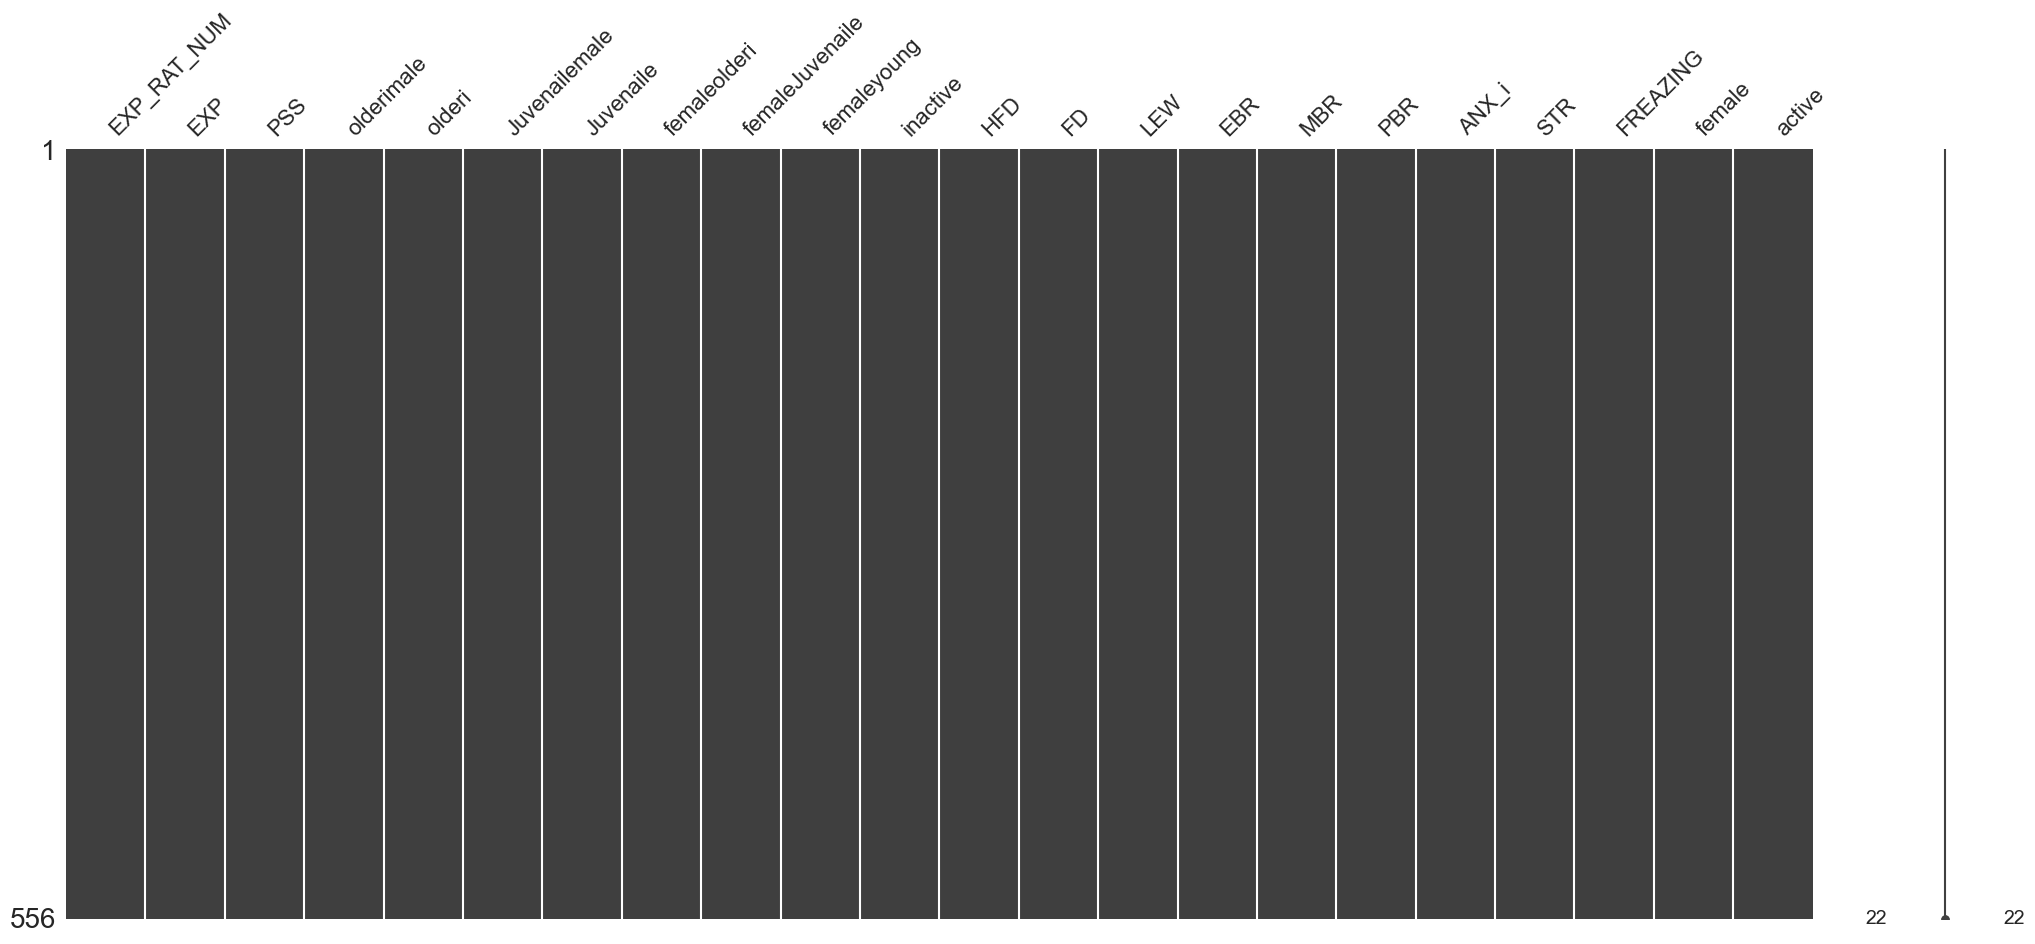

In [2]:

# 1. Load the dataset
df = pd.read_csv('/Users/djourno/PyCharm/SEM_PSS/data.csv')

# 2. Show basic info
print("Columns in the dataset:")
print(df.columns.tolist())
print("\nSample of Raw Data:")
print(df.head())

# 3. Check for constant columns and NaN
constant_columns = df.loc[:, df.nunique() <= 1].columns.tolist()
nan_columns = df.columns[df.isna().any()].tolist()
print("\nConstant columns:", constant_columns)
print("Columns with NaN values:", nan_columns)

# 4. תיאור בסיסי ובדיקת חוסרים
print("\nDescriptive statistics:")
print(df.describe(include='all'))
msno.matrix(df)
plt.show()

# 5. מרכוז ונרמול משתנים
scaler = MinMaxScaler()

# STR
df['STR_norm'] = scaler.fit_transform(df[['STR']])
df['STR_c'] = df['STR_norm'] - df['STR_norm'].mean()

# FREAZING
df['FREAZING_norm'] = scaler.fit_transform(df[['FREAZING']])
df['FREAZING_c'] = df['FREAZING_norm'] - df['FREAZING_norm'].mean()

# ANX_i
df['ANX_i_c'] = df['ANX_i'] - df['ANX_i'].mean()

In [3]:

# פונקציה לניקוי הדאטה (שומרת על פיצ'רים חשובים אם צריך)
def clean_data_for_regression(df, correlation_threshold=0.95, protected_columns=None):
    if protected_columns is None:
        protected_columns = []

    # Drop constant columns
    constant_cols = df.loc[:, df.nunique() <= 1].columns.tolist()
    df = df.drop(columns=constant_cols)
    print(f"Dropped constant columns: {constant_cols}")

    # Drop one of each highly correlated pair, unless protected
    corr_matrix = df.corr(numeric_only=True).abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = []
    for column in upper_triangle.columns:
        if any(upper_triangle[column] > correlation_threshold) and column not in protected_columns:
            to_drop.append(column)

    df = df.drop(columns=to_drop)
    print(f"Dropped highly correlated columns (excluding protected ones): {to_drop}")

    return df

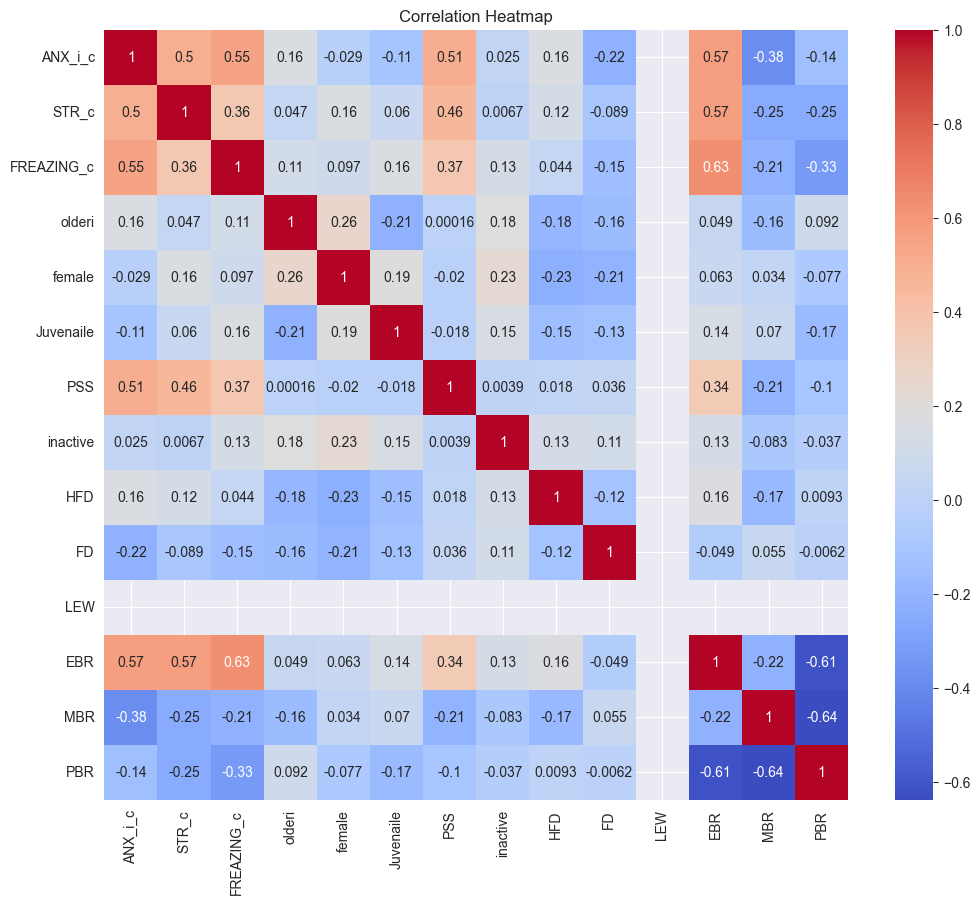

In [4]:

# 6. מטריצת קורלציות (Pearson בין רציפים)
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'LEW', 'EBR', 'MBR', 'PBR']

# חישוב קורלציות
corr = pg.pairwise_corr(df[cont_vars + bin_vars], method='pearson')

# הצגת מטריצת חום
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_vars + bin_vars].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [5]:

#7. ניקוי דאטה (בלי למחוק פיצ'רים חשובים שיצרנו)
protected = ['STR_norm', 'STR_c', 'FREAZING_norm', 'FREAZING_c', 'ANX_i_c']
df = clean_data_for_regression(df, protected_columns=protected)


Dropped constant columns: ['LEW']
Dropped highly correlated columns (excluding protected ones): ['active']


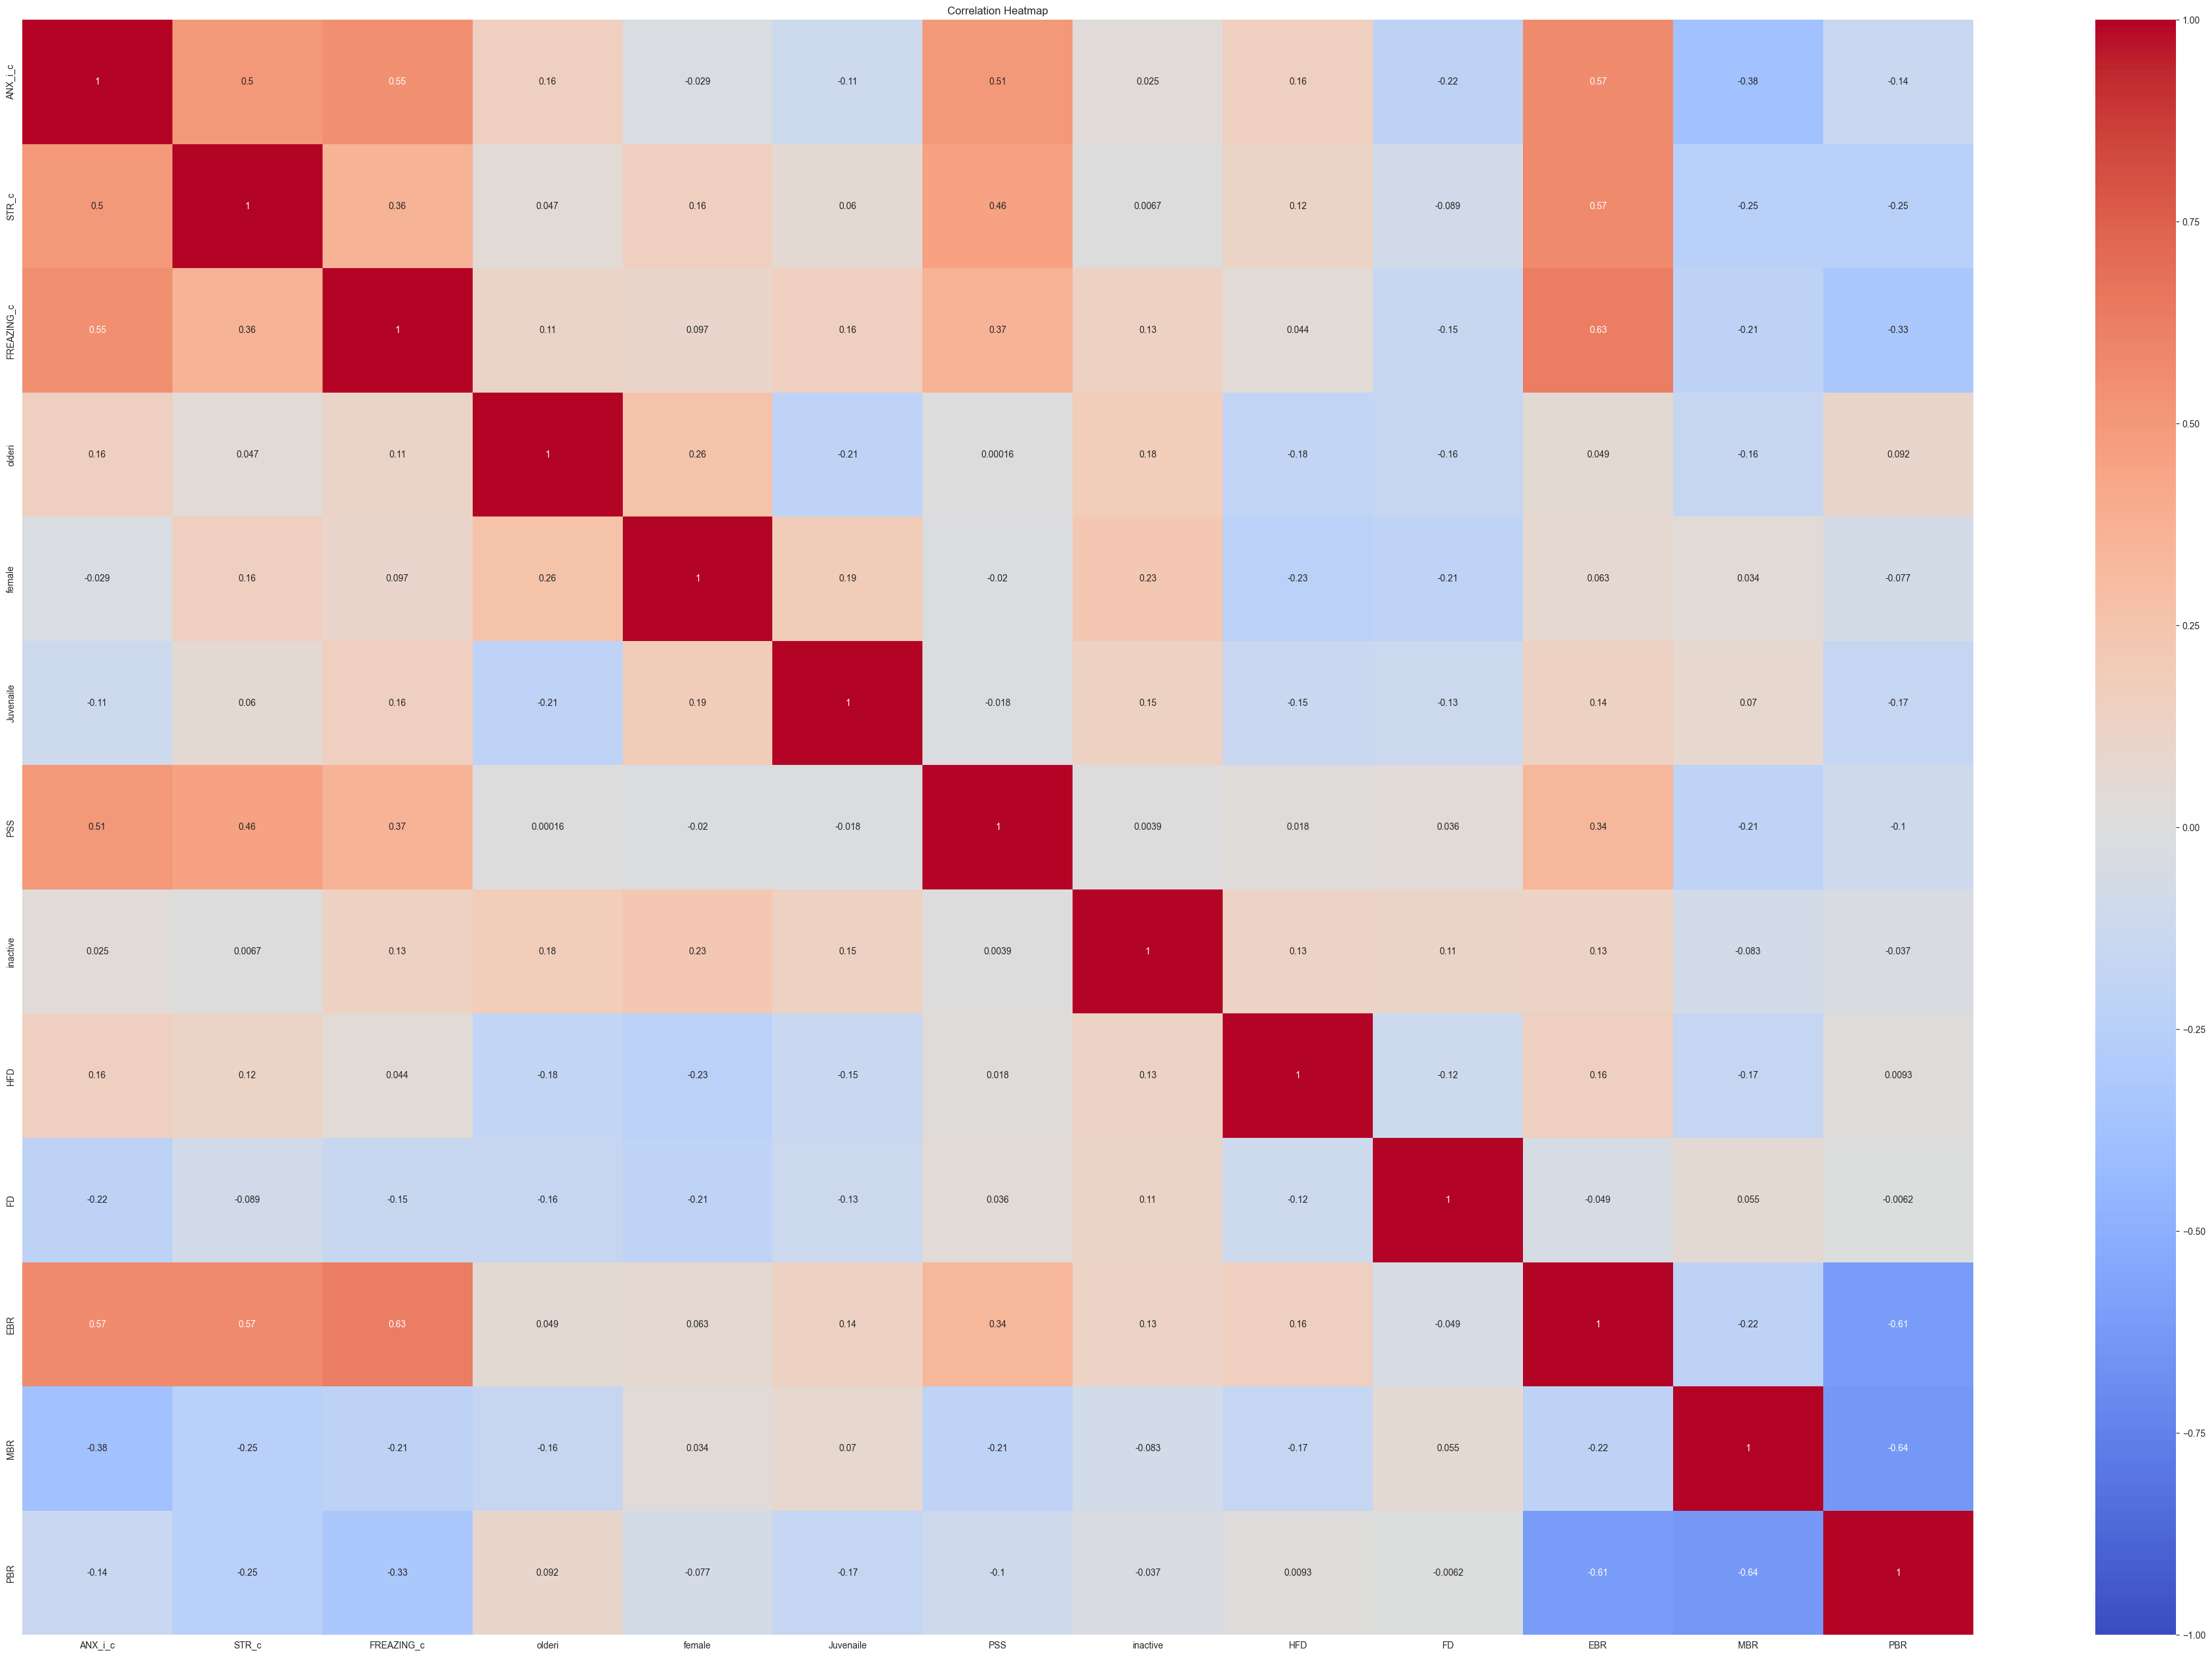


Detailed Correlation Matrix:
          X           Y   method alternative    n         r           CI95%  \
0   ANX_i_c       STR_c  pearson   two-sided  556  0.500290    [0.44, 0.56]   
1   ANX_i_c  FREAZING_c  pearson   two-sided  556  0.548358     [0.49, 0.6]   
2   ANX_i_c      olderi  pearson   two-sided  556  0.159987    [0.08, 0.24]   
3   ANX_i_c      female  pearson   two-sided  556 -0.028519   [-0.11, 0.05]   
4   ANX_i_c   Juvenaile  pearson   two-sided  556 -0.110774  [-0.19, -0.03]   
..      ...         ...      ...         ...  ...       ...             ...   
73       FD         MBR  pearson   two-sided  556  0.055228   [-0.03, 0.14]   
74       FD         PBR  pearson   two-sided  556 -0.006218   [-0.09, 0.08]   
75      EBR         MBR  pearson   two-sided  556 -0.216535  [-0.29, -0.14]   
76      EBR         PBR  pearson   two-sided  556 -0.614279  [-0.66, -0.56]   
77      MBR         PBR  pearson   two-sided  556 -0.637355  [-0.68, -0.59]   

           p-unc     

In [6]:
# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'EBR', 'MBR', 'PBR']

# שמירת הדאטה המקורי לפני הצמצום
df_old = df.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df = df[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 9. בדיקת VIF
X = df.assign(const=1)  # הוספת קבוע

# חישוב VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# הצגת ה-VIF
print("\nVariance Inflation Factors (VIF):")
print(vif_data)

# חיפוש משתנים בעייתיים
problematic = vif_data[vif_data['VIF'] > 10]
print("\nVariables with VIF > 10:")
print(problematic)


Variance Inflation Factors (VIF):
      Variable       VIF
0      ANX_i_c  2.430867
1        STR_c  1.864943
2   FREAZING_c  1.978049
3       olderi  1.389019
4       female  1.372394
5    Juvenaile  1.372014
6          PSS  1.557481
7     inactive  1.291492
8          HFD  1.368797
9           FD  1.353470
10         EBR       inf
11         MBR       inf
12         PBR       inf
13       const  0.000000

Variables with VIF > 10:
   Variable  VIF
10      EBR  inf
11      MBR  inf
12      PBR  inf


/Users/djourno/PyCharm/SEM_PSS/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/djourno/PyCharm/SEM_PSS/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [8]:
df = df.drop(columns=['MBR'])
# חישוב VIF מחדש אחרי הדרופ
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF) after dropping 'MBR':")
print(vif_data)


New Variance Inflation Factors (VIF) after dropping 'MBR':
      Variable       VIF
0      ANX_i_c  2.430867
1        STR_c  1.864943
2   FREAZING_c  1.978049
3       olderi  1.389019
4       female  1.372394
5    Juvenaile  1.372014
6          PSS  1.557481
7     inactive  1.291492
8          HFD  1.368797
9           FD  1.353470
10         EBR  3.779097
11         PBR  1.885146


In [9]:

# 1. female × olderi
df['female_x_olderi']    = df['female'] * df['olderi']

# 2. female × Juvenaile
df['female_x_Juvenaile'] = df['female'] * df['Juvenaile']

# חישוב VIF מחדש אחרי הוספה
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)


New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  2.470307
1                STR_c  2.002074
2           FREAZING_c  2.008851
3               olderi  2.548432
4               female  2.926226
5            Juvenaile  2.406482
6                  PSS  1.603151
7             inactive  1.365965
8                  HFD  1.420640
9                   FD  1.445674
10                 EBR  3.798351
11                 PBR  1.925510
12     female_x_olderi  3.558756
13  female_x_Juvenaile  2.913910


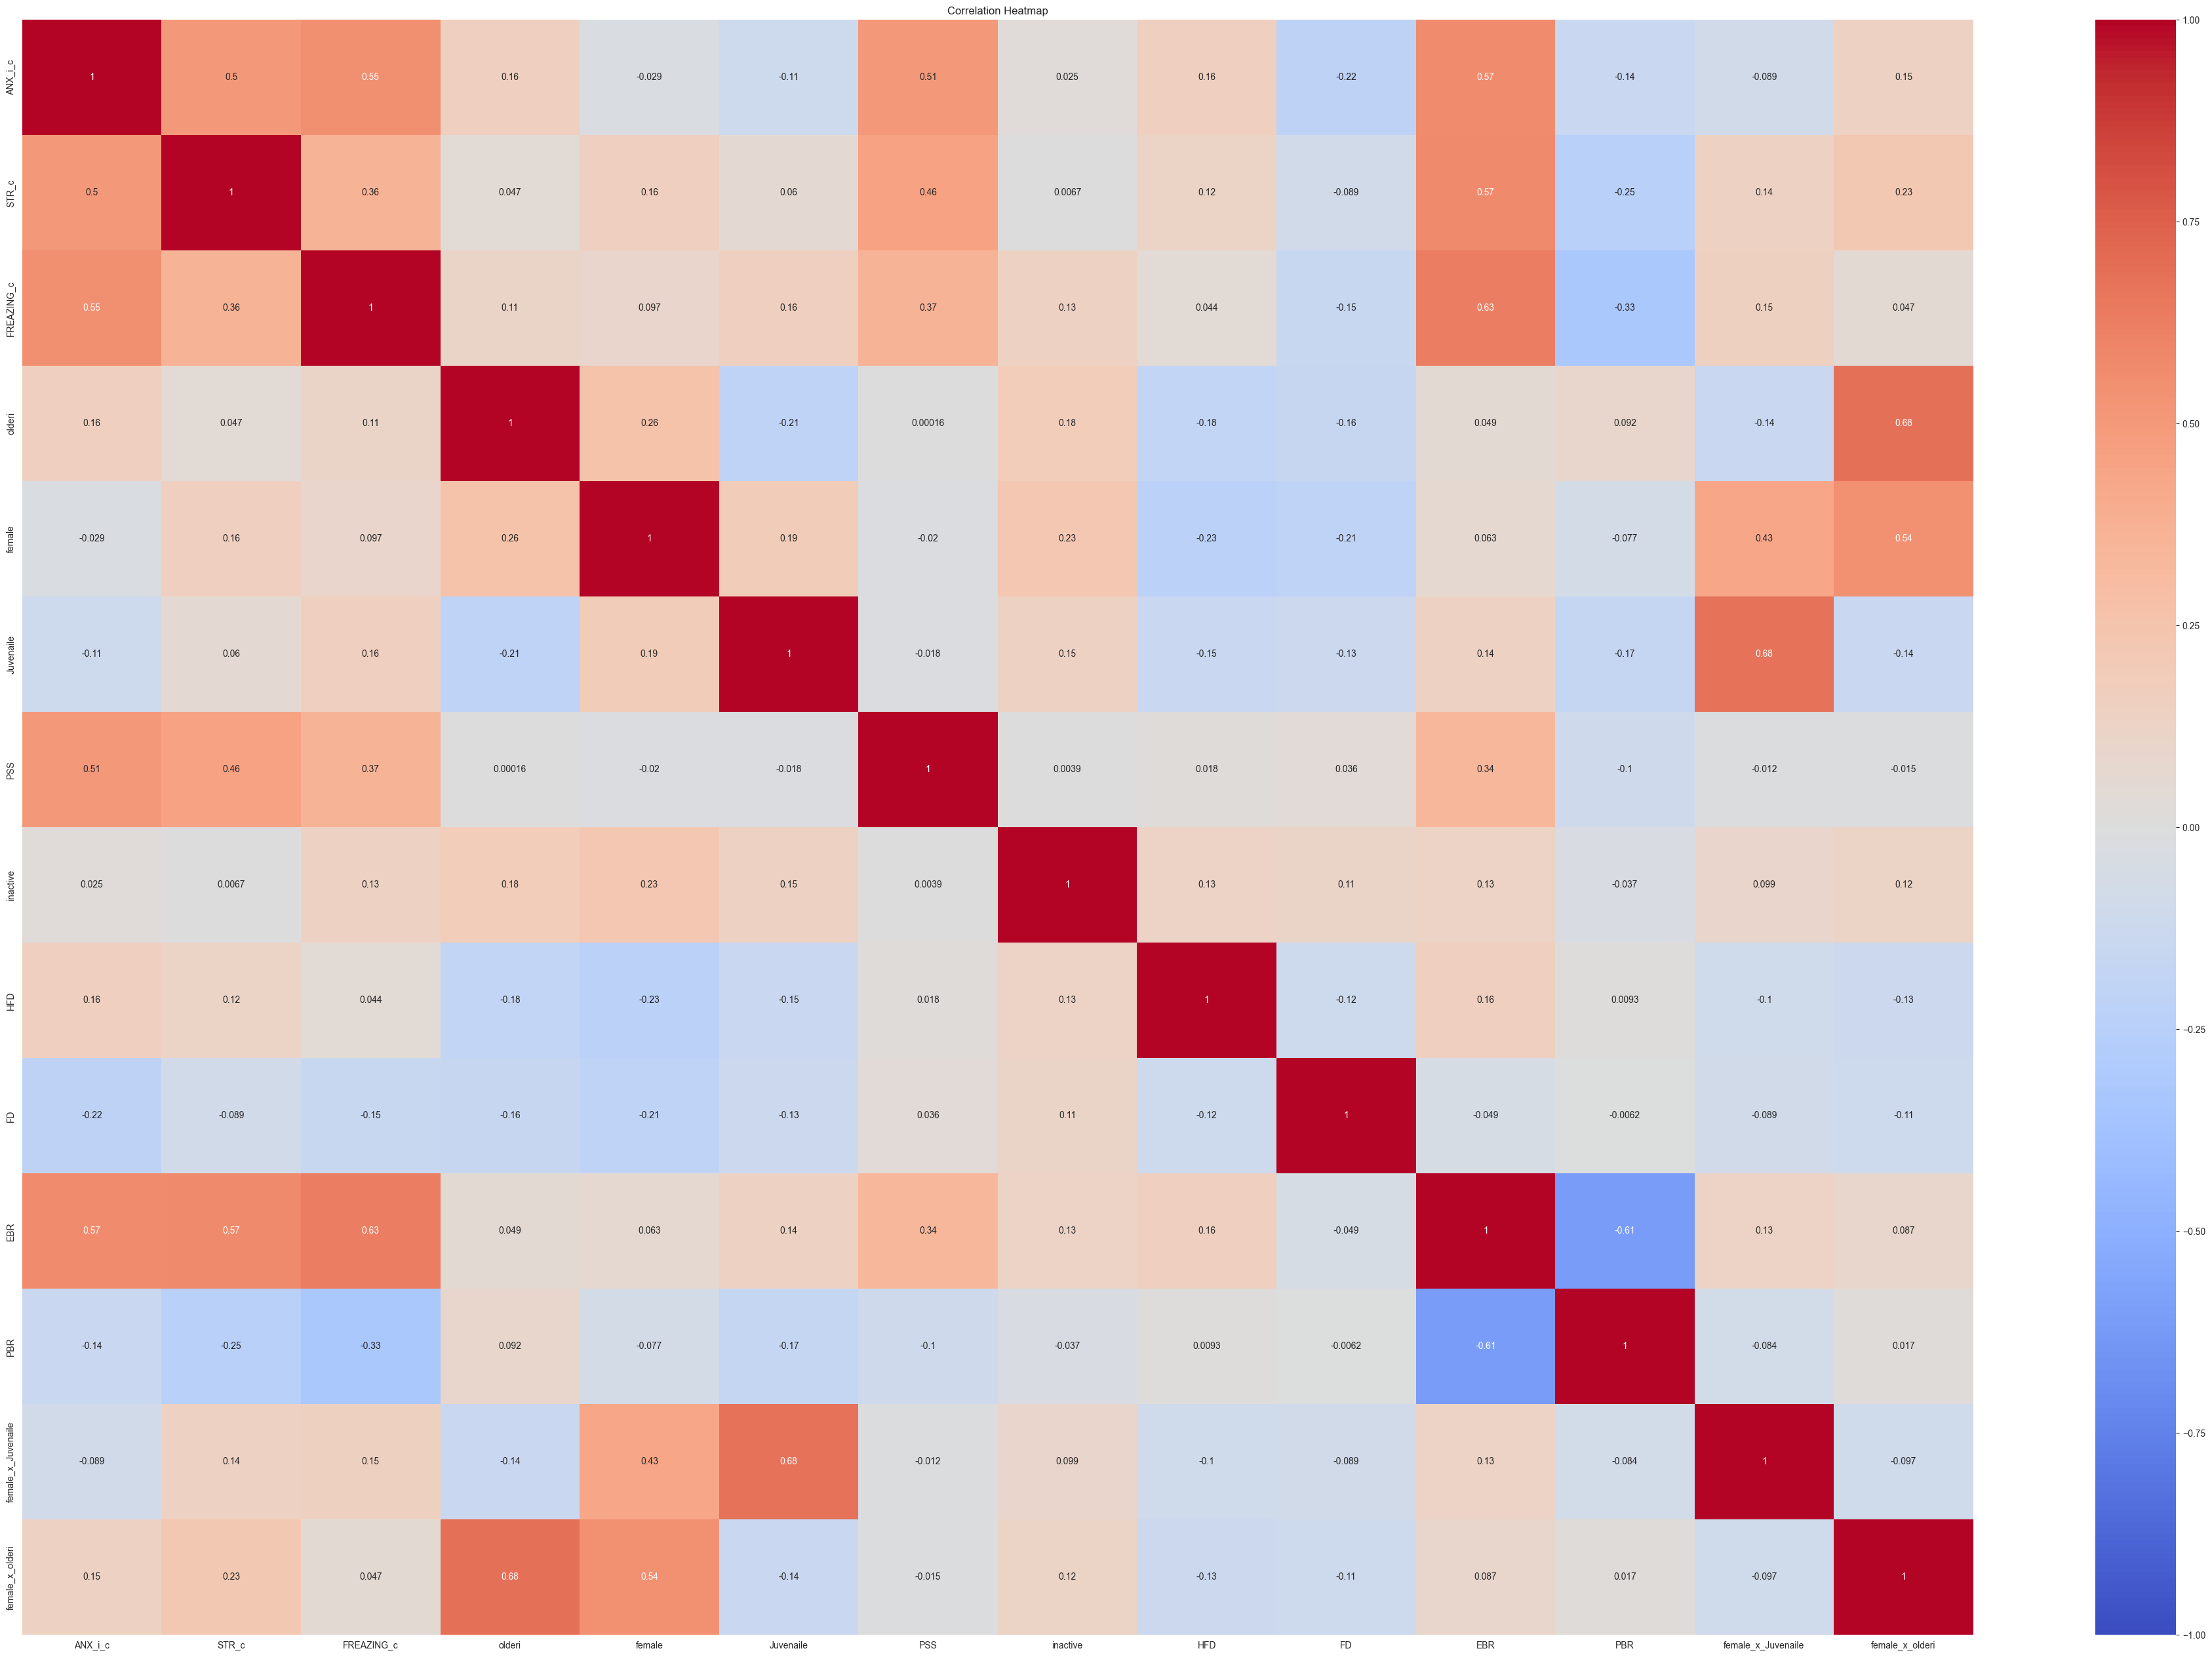


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  556   
1              ANX_i_c          FREAZING_c  pearson   two-sided  556   
2              ANX_i_c              olderi  pearson   two-sided  556   
3              ANX_i_c              female  pearson   two-sided  556   
4              ANX_i_c           Juvenaile  pearson   two-sided  556   
..                 ...                 ...      ...         ...  ...   
86                 EBR  female_x_Juvenaile  pearson   two-sided  556   
87                 EBR     female_x_olderi  pearson   two-sided  556   
88                 PBR  female_x_Juvenaile  pearson   two-sided  556   
89                 PBR     female_x_olderi  pearson   two-sided  556   
90  female_x_Juvenaile     female_x_olderi  pearson   two-sided  556   

           r           CI95%         p-unc       BF10     power  
0   0.500290    [0.44, 0.56]  1.492239e

In [10]:
# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_old = df.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df = df[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

In [11]:

# 3. תיאור מודל SEM ()
model_desc = """
ANX_i_c      ~ PSS
STR_c        ~ PSS
FREAZING_c   ~ PSS

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 5. פונקציית fitting
def fit_sem(subdf):
	m = Model(model_desc)
	m.fit(subdf)
	stats = calc_stats(m)
	return m, stats

# 6. ריצה
model, stats = fit_sem(df)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS:")
print(model.inspect().to_string())


SEM Fit Comparison PSS:
             Chi2  DoF       CFI     RMSEA        AIC         BIC
Value  249.790059    4  0.817214  0.332741  33.101475  106.554536

Parameter Estimates PSS:
          lval  op        rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~         PSS  0.157908  0.011397  13.854668  0.000000e+00
1        STR_c   ~         PSS  0.148409  0.012196  12.168607  0.000000e+00
2   FREAZING_c   ~         PSS  0.124302  0.013362   9.302634  0.000000e+00
3          EBR   ~     ANX_i_c  0.428260  0.089273   4.797218  1.608842e-06
4          EBR   ~       STR_c  0.774444  0.077195  10.032268  0.000000e+00
5          EBR   ~  FREAZING_c  0.927481  0.076363  12.145756  0.000000e+00
6          PBR   ~     ANX_i_c  0.433177  0.156888   2.761063  5.761348e-03
7          PBR   ~       STR_c -0.587900  0.135663  -4.333528  1.467387e-05
8          PBR   ~  FREAZING_c -0.943161  0.134200  -7.028041  2.094547e-12
9      ANX_i_c  ~~       STR_c  0.006740  0.000866   7.77

In [12]:

# ---------- 2. ריצה יחידה וחילוץ נתיבים ----------
def single_run(data, model_desc):
    """מחזיר dict עם כל הנתיבים הישירים + כל הנתיבים העקיפים (X→M→Y)."""
    m = Model(model_desc)
    m.fit(data, obj="MLW")
    est = m.inspect()

    # --- נתיבים ישירים ---
    direct = {(row.lval, row.rval): row.Estimate
              for _, row in est[est.op == "~"].iterrows()}

    # --- מציאת כל X→M→Y האפשריים ---
    indirect = {}
    # אקסוגניות: משתנים שמופיעים רק כ-predictors (אין להם חץ נכנס)
    lhs_set = set(k[0] for k in direct)
    exogenous = set(k[1] for k in direct) - lhs_set

    for (m, x), a in direct.items():      # x → m
        for (y, m2), b in direct.items(): # m → y
            if m == m2 and x != y:        # אותה חוליה, אין מסלול מקוצר
                # נדרש שמקור המסלול יהיה אקסוגני (לפי רוב ניתוחי מֶדיאציה)
                if x in exogenous:
                    indirect[f"{x} → {m} → {y}"] = a * b

    # החזרת COMBINED dict
    return {**{f"{k[0]} ← {k[1]}": v for k, v in direct.items()},
            **indirect}

# ---------- 3. Bootstrap ----------
def bootstrap_sem(model_desc, data: pd.DataFrame,
                  n_boot: int = 2000,
                  random_state: int | None = None
                 , ) -> tuple[pd.DataFrame, pd.DataFrame]:

    rng, rows = np.random.default_rng(random_state), []
    for _ in range(n_boot):
        resample = data.sample(len(data), replace=True,
                               random_state=rng.integers(1e9))
        try:
            rows.append(single_run(resample , model_desc))
        except Exception:
            continue

    boot_df = pd.DataFrame(rows)


    # ---------- טבלת סיכום ----------
    summ = (boot_df.agg(['mean', 'std']).T
            .rename(columns={'mean': 'Estimate', 'std': 'SE'}))
    summ['CI_lo']   = boot_df.quantile(0.025)
    summ['CI_hi']   = boot_df.quantile(0.975)
    summ['CI_w']    = summ['CI_hi'] - summ['CI_lo']          # רוחב CI
    summ['Z']       = summ['Estimate'] / summ['SE']          # Z-score

    # p-value לא-פרמטרי: 2·min(P(<0), P(>0))
    pvals = boot_df.apply(
        lambda col: 2 * min((col <= 0).mean(), (col >= 0).mean()),
        axis=0)
    summ['p_boot'] = pvals

    # סמן מובהקות לפי p<0.05 (או CI שלא חותך 0)
    summ['Sig (p<.05)'] = summ['p_boot'] < .05

    return boot_df, summ


# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000, random_state=42)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap:")
print(indirect_summary.round(3).to_string())




אפקטים ישירים – Bootstrap:
                  Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← PSS        0.158  0.011  0.136  0.181  0.045  13.825   0.000         True
STR_c ← PSS          0.148  0.012  0.125  0.172  0.047  12.127   0.000         True
FREAZING_c ← PSS     0.125  0.013  0.099  0.150  0.051   9.796   0.000         True
EBR ← ANX_i_c        0.429  0.091  0.251  0.610  0.359   4.703   0.000         True
EBR ← STR_c          0.773  0.090  0.592  0.948  0.356   8.572   0.000         True
EBR ← FREAZING_c     0.926  0.085  0.767  1.094  0.327  10.884   0.000         True
PBR ← ANX_i_c        0.434  0.168  0.115  0.761  0.646   2.593   0.009         True
PBR ← STR_c         -0.588  0.142 -0.867 -0.308  0.559  -4.134   0.000         True
PBR ← FREAZING_c    -0.937  0.127 -1.186 -0.690  0.495  -7.361   0.000         True

אפקטים עקיפים (תיווך) – Bootstrap:
                        Estimate     SE  CI_lo  CI_hi   CI_w      Z  p_boot  Sig (p<.05)
PSS → A

SEM diagram for PSS saved as sem_diagram_pss.png


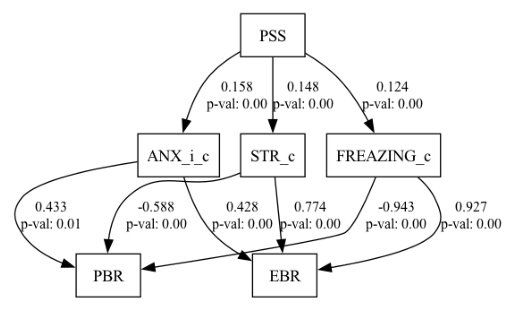

In [13]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss.png")
print("SEM diagram for PSS saved as sem_diagram_pss.png")
plt.imshow(plt.imread("sem_diagram_pss.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

In [14]:
# =====================================================================
# 3. תיאור מודל SEM (ללא PSS בתוך המשוואות)
model_desc = """
ANX_i_c      ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile
STR_c        ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile
FREAZING_c   ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 4. פיצול הדאטה
df0 = df[df['PSS'] == 0].copy()
df1 = df[df['PSS'] == 1].copy()


New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  1.899367
1                STR_c  1.936392
2           FREAZING_c  1.296379
3               olderi  2.753174
4               female  2.880944
5            Juvenaile  2.419577
6             inactive  1.421942
7                  HFD  1.567316
8                   FD  1.694911
9                  EBR  1.874923
10                 PBR  1.314650
11  female_x_Juvenaile  3.026076
12     female_x_olderi  4.104322


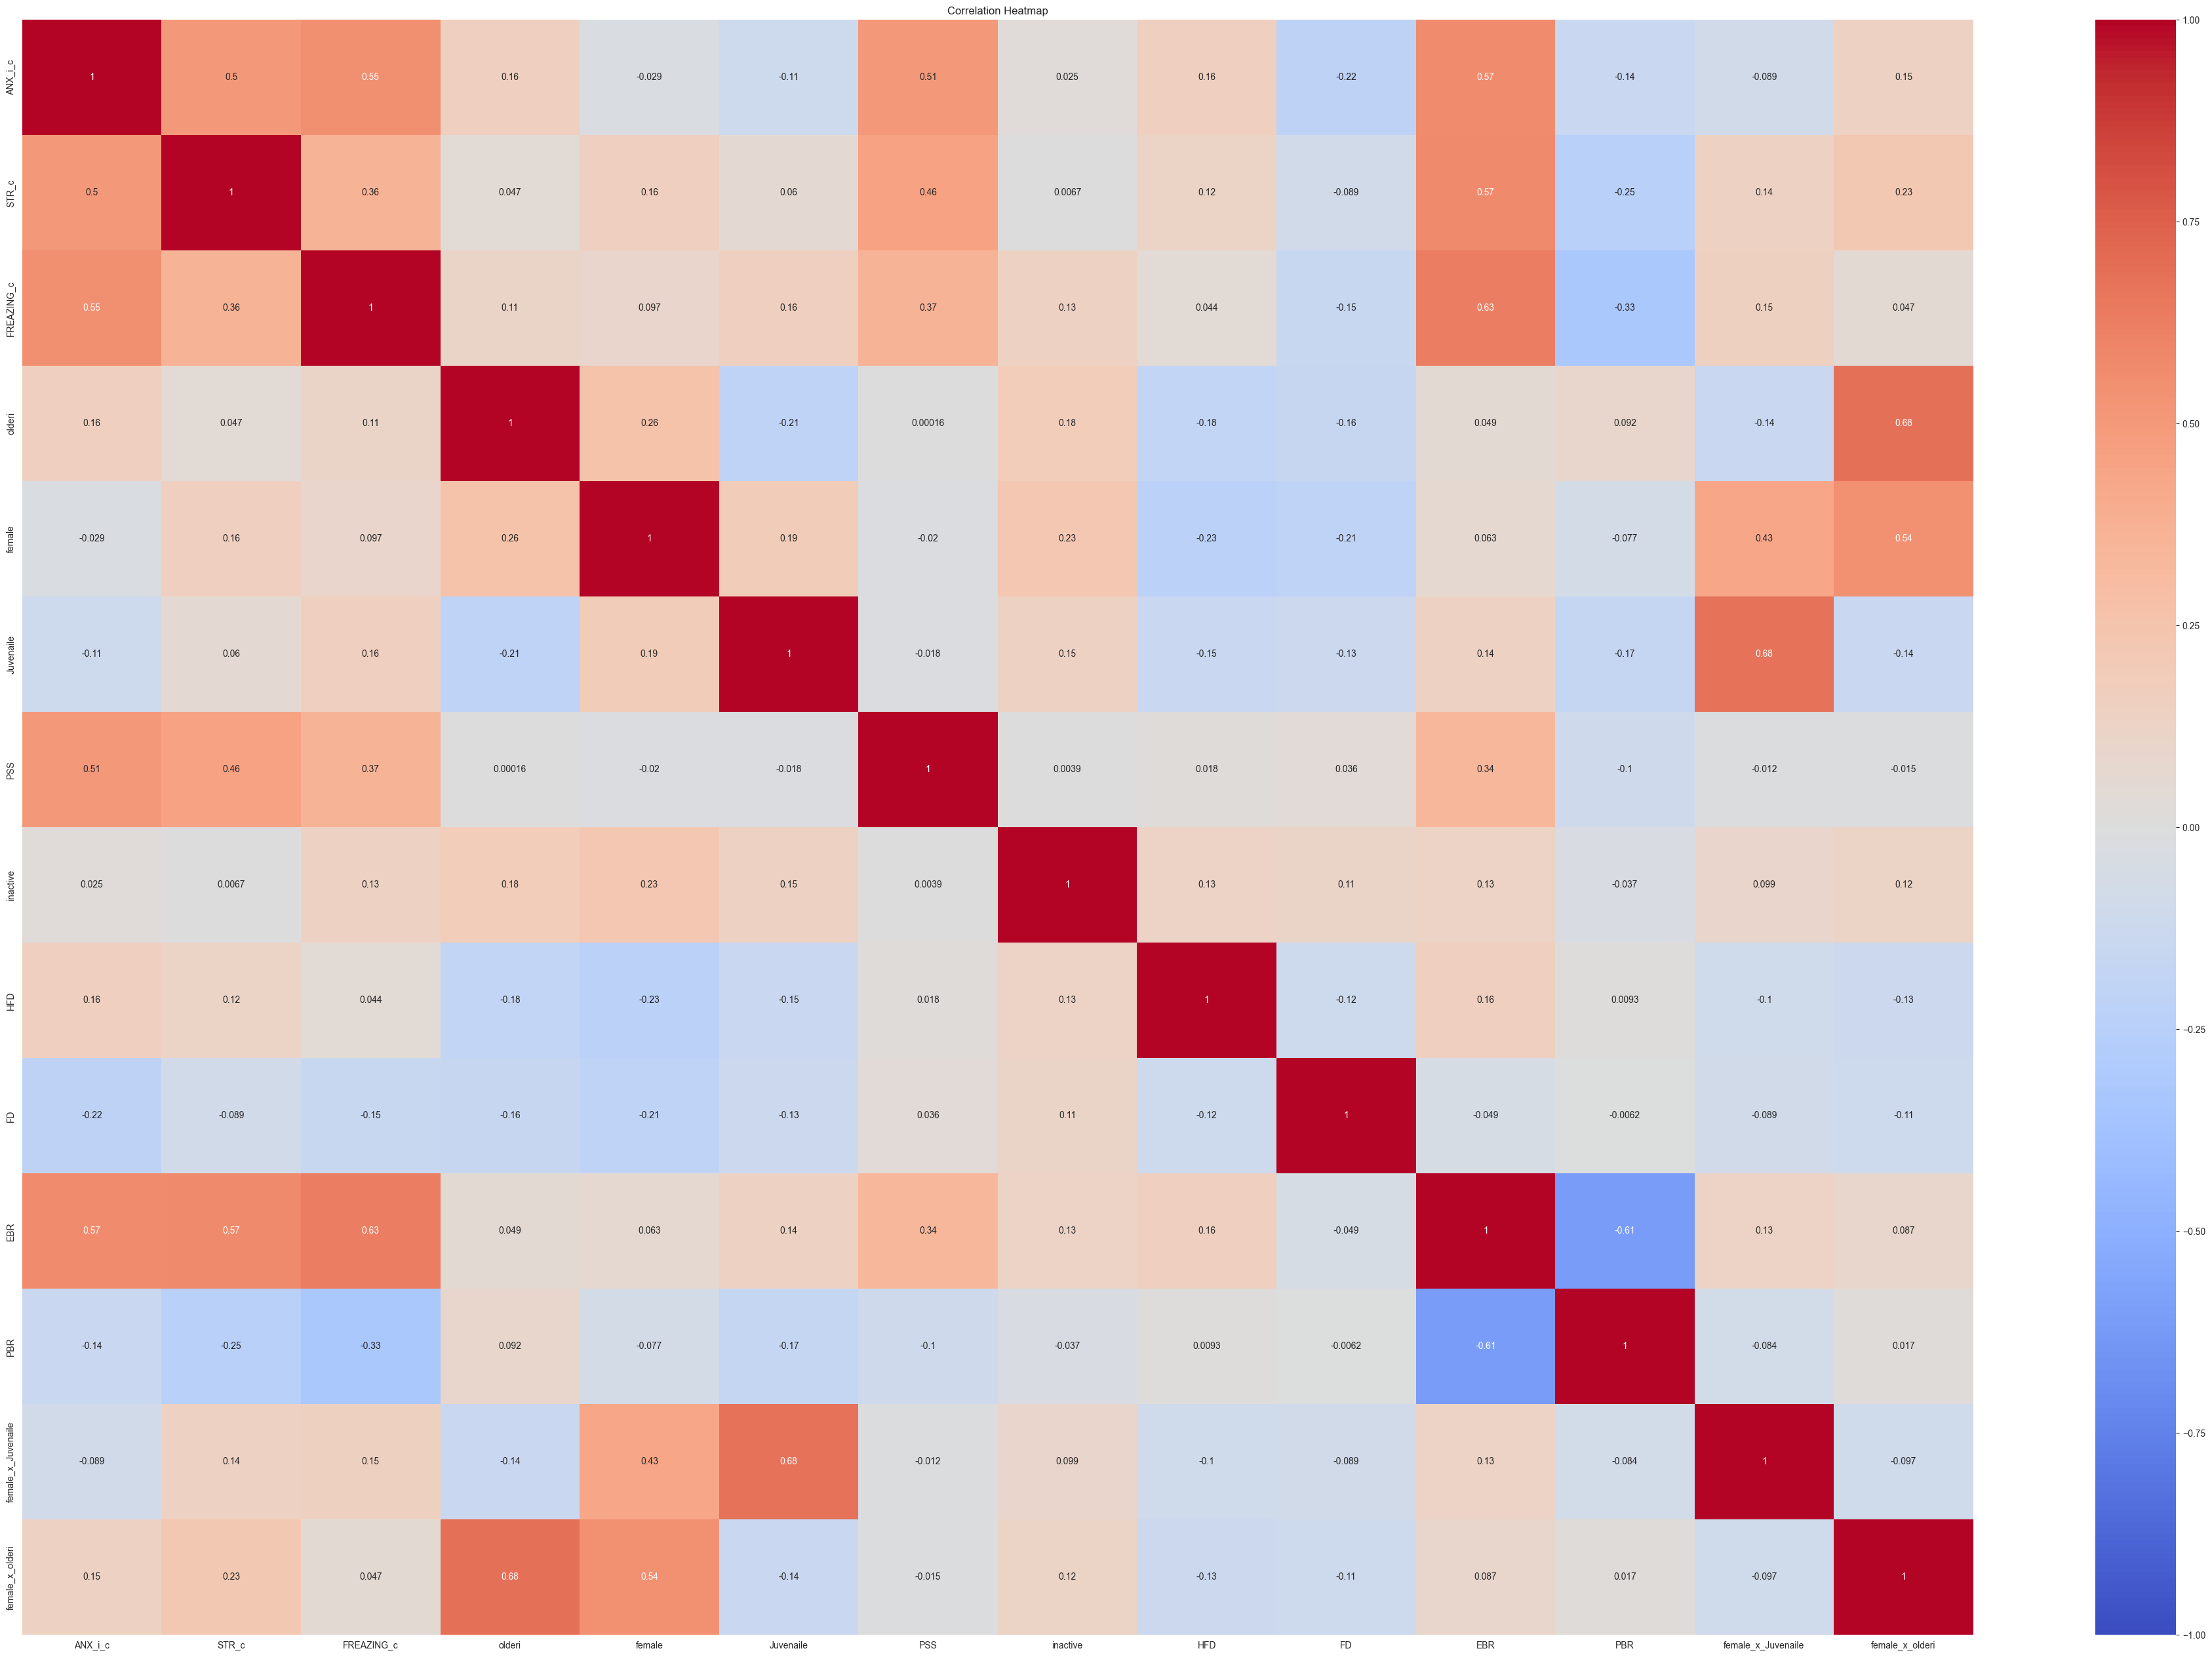


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  266   
1              ANX_i_c          FREAZING_c  pearson   two-sided  266   
2              ANX_i_c              olderi  pearson   two-sided  266   
3              ANX_i_c              female  pearson   two-sided  266   
4              ANX_i_c           Juvenaile  pearson   two-sided  266   
..                 ...                 ...      ...         ...  ...   
73                 EBR  female_x_Juvenaile  pearson   two-sided  266   
74                 EBR     female_x_olderi  pearson   two-sided  266   
75                 PBR  female_x_Juvenaile  pearson   two-sided  266   
76                 PBR     female_x_olderi  pearson   two-sided  266   
77  female_x_Juvenaile     female_x_olderi  pearson   two-sided  266   

           r           CI95%         p-unc       BF10     power  
0   0.266874    [0.15, 0.38]  1.022415e

In [15]:
df0 = df0.drop(columns=['PSS'])

# חישוב VIF מחדש אחרי חלוקה
X = df0.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_0old = df0.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df0 = df0[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df0, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)



New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  2.674581
1                STR_c  1.665353
2           FREAZING_c  2.475759
3               olderi  2.457515
4               female  3.141648
5            Juvenaile  2.629387
6             inactive  1.474311
7                  HFD  1.431947
8                   FD  1.467654
9                  EBR  6.741328
10                 PBR  3.482554
11  female_x_Juvenaile  3.022701
12     female_x_olderi  3.398718


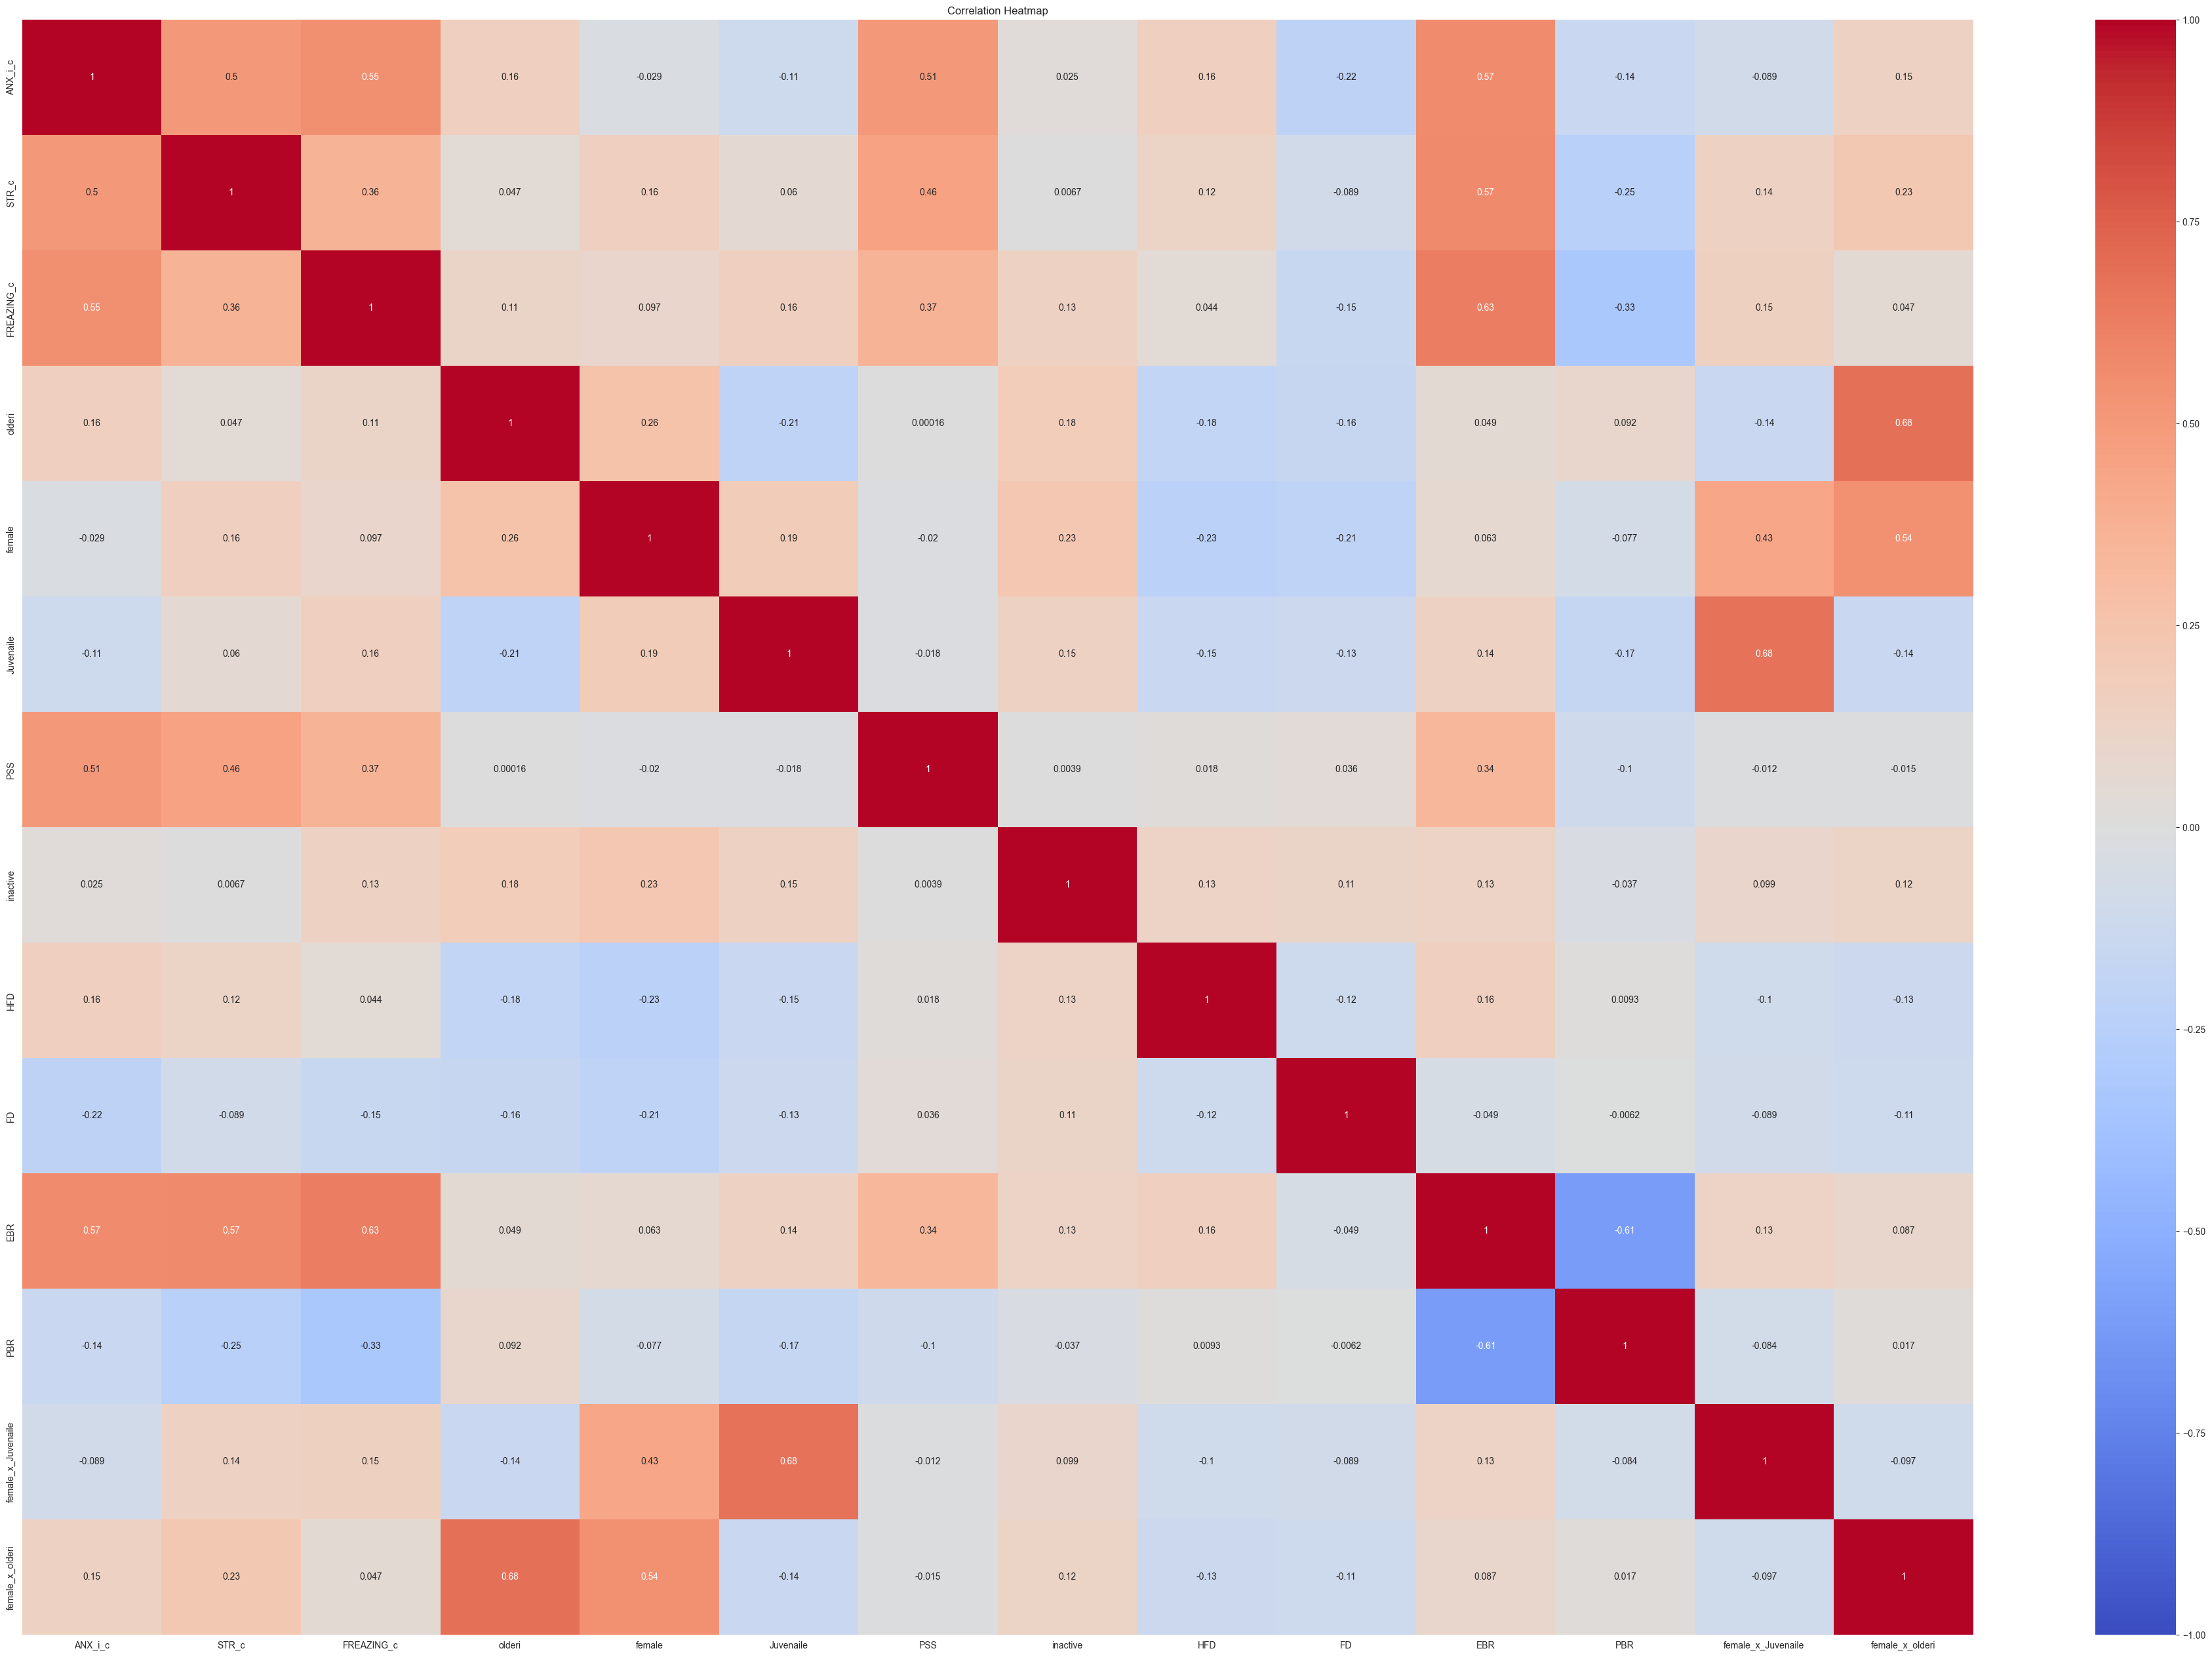


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  290   
1              ANX_i_c          FREAZING_c  pearson   two-sided  290   
2              ANX_i_c              olderi  pearson   two-sided  290   
3              ANX_i_c              female  pearson   two-sided  290   
4              ANX_i_c           Juvenaile  pearson   two-sided  290   
..                 ...                 ...      ...         ...  ...   
73                 EBR  female_x_Juvenaile  pearson   two-sided  290   
74                 EBR     female_x_olderi  pearson   two-sided  290   
75                 PBR  female_x_Juvenaile  pearson   two-sided  290   
76                 PBR     female_x_olderi  pearson   two-sided  290   
77  female_x_Juvenaile     female_x_olderi  pearson   two-sided  290   

           r           CI95%         p-unc       BF10     power  
0   0.450852    [0.35, 0.54]  6.326796e

In [16]:
df1 = df1.drop(columns=['PSS'])

# חישוב VIF מחדש אחרי חלוקה
X = df1.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_1old = df1.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df1 = df1[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df1, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)


In [17]:


# 6. ריצה
model, stats = fit_sem(df0)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_0:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_0:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_0:
             Chi2  DoF       CFI     RMSEA       AIC         BIC
Value  121.196298   53  0.939586  0.069682  75.08875  211.261609

Parameter Estimates PSS_0:
          lval  op                rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~              olderi -0.007064  0.030254  -0.233479  8.153894e-01
1      ANX_i_c   ~              female -0.047358  0.028418  -1.666447  9.562449e-02
2      ANX_i_c   ~           Juvenaile -0.128406  0.032815  -3.913078  9.112722e-05
3      ANX_i_c   ~            inactive  0.019661  0.028418   0.691840  4.890377e-01
4      ANX_i_c   ~                 HFD  0.071018  0.028743   2.470770  1.348226e-02
5      ANX_i_c   ~                  FD -0.241643  0.031676  -7.628528  2.375877e-14
6      ANX_i_c   ~     female_x_olderi  0.106111  0.044633   2.377430  1.743376e-02
7      ANX_i_c   ~  female_x_Juvenaile  0.121386  0.049222   2.466088  1.365976e-02
8        STR_c   ~              olderi -0.089909  0.024989 

In [18]:


# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000, random_state=42)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap PSS_0:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_0:")
print(indirect_summary.round(3).to_string())




אפקטים ישירים – Bootstrap PSS_0:
                                 Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                    0.008  0.020 -0.032  0.048  0.080   0.408   0.689        False
ANX_i_c ← female                   -0.071  0.021 -0.111 -0.029  0.082  -3.367   0.002         True
ANX_i_c ← Juvenaile                -0.057  0.033 -0.123  0.007  0.131  -1.717   0.090        False
ANX_i_c ← inactive                  0.032  0.020 -0.005  0.071  0.076   1.656   0.097        False
ANX_i_c ← HFD                       0.047  0.019  0.010  0.084  0.074   2.398   0.016         True
ANX_i_c ← FD                       -0.126  0.033 -0.190 -0.063  0.127  -3.810   0.000         True
ANX_i_c ← female_x_olderi           0.107  0.030  0.047  0.167  0.120   3.515   0.001         True
ANX_i_c ← female_x_Juvenaile        0.057  0.049 -0.036  0.153  0.190   1.165   0.238        False
STR_c ← olderi                     -0.072  0.027 -0.127 -0.018  0.109  -2.6

SEM diagram for PSS saved as sem_diagram_pss_0.png


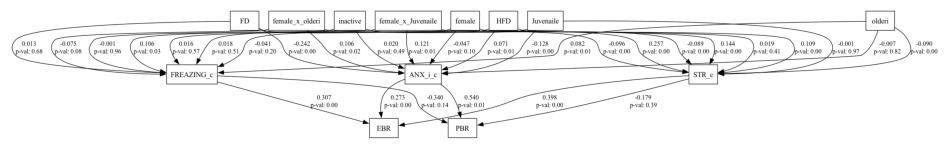

In [19]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_0.png")
print("SEM diagram for PSS saved as sem_diagram_pss_0.png")
plt.figure(figsize=(12, 8))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_0.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

In [20]:


# 6. ריצה
model, stats = fit_sem(df1)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_1:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_1:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_1:
             Chi2  DoF       CFI     RMSEA        AIC        BIC
Value  281.728471   53  0.866427  0.122201  74.057045  213.51252

Parameter Estimates PSS_1:
          lval  op                rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~              olderi  0.010002  0.024078   0.415382  6.778625e-01
1      ANX_i_c   ~              female -0.097512  0.023568  -4.137415  3.512405e-05
2      ANX_i_c   ~           Juvenaile  0.017290  0.027822   0.621435  5.343136e-01
3      ANX_i_c   ~            inactive  0.048754  0.023568   2.068645  3.857944e-02
4      ANX_i_c   ~                 HFD  0.013884  0.022896   0.606378  5.442640e-01
5      ANX_i_c   ~                  FD -0.061632  0.024078  -2.559692  1.047651e-02
6      ANX_i_c   ~     female_x_olderi  0.125159  0.036506   3.428414  6.071188e-04
7      ANX_i_c   ~  female_x_Juvenaile -0.007455  0.041489  -0.179694  8.573931e-01
8        STR_c   ~              olderi -0.071229  0.031621 

In [21]:

# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000, random_state=42)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap PSS_1:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_1:")
print(indirect_summary.round(3).to_string())




אפקטים ישירים – Bootstrap PSS_1:
                                 Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                    0.008  0.020 -0.032  0.048  0.080   0.408   0.689        False
ANX_i_c ← female                   -0.071  0.021 -0.111 -0.029  0.082  -3.367   0.002         True
ANX_i_c ← Juvenaile                -0.057  0.033 -0.123  0.007  0.131  -1.717   0.090        False
ANX_i_c ← inactive                  0.032  0.020 -0.005  0.071  0.076   1.656   0.097        False
ANX_i_c ← HFD                       0.047  0.019  0.010  0.084  0.074   2.398   0.016         True
ANX_i_c ← FD                       -0.126  0.033 -0.190 -0.063  0.127  -3.810   0.000         True
ANX_i_c ← female_x_olderi           0.107  0.030  0.047  0.167  0.120   3.515   0.001         True
ANX_i_c ← female_x_Juvenaile        0.057  0.049 -0.036  0.153  0.190   1.165   0.238        False
STR_c ← olderi                     -0.072  0.027 -0.127 -0.018  0.109  -2.6

SEM diagram for PSS saved as sem_diagram_pss_1.png


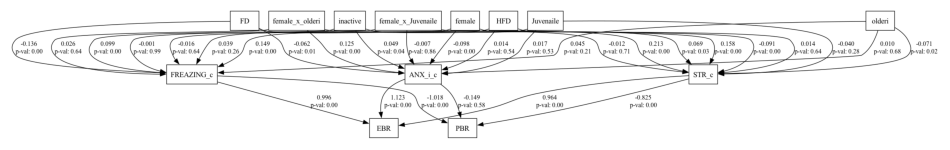

In [22]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_1.png")
print("SEM diagram for PSS saved as sem_diagram_pss_1.png")
plt.figure(figsize=(12, 8))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_1.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()


New Variance Inflation Factors (VIF):
                    Variable        VIF
0                    ANX_i_c   2.785492
1                      STR_c   2.232922
2                 FREAZING_c   2.187655
3                     olderi   5.459303
4                     female   5.844893
5                  Juvenaile   4.770254
6                        PSS   9.367670
7                   inactive   2.836488
8                        HFD   3.070397
9                         FD   3.537253
10                       EBR   3.951821
11                       PBR   2.007993
12        female_x_Juvenaile   5.746077
13           female_x_olderi   7.313214
14              PSS_x_olderi   5.773947
15              PSS_x_female   6.935545
16           PSS_x_Juvenaile   5.187456
17            PSS_x_inactive  14.242673
18                 PSS_x_HFD   3.258974
19                  PSS_x_FD   3.546667
20  PSS_x_female_x_Juvenaile   5.799497
21     PSS_x_female_x_olderi   6.881111


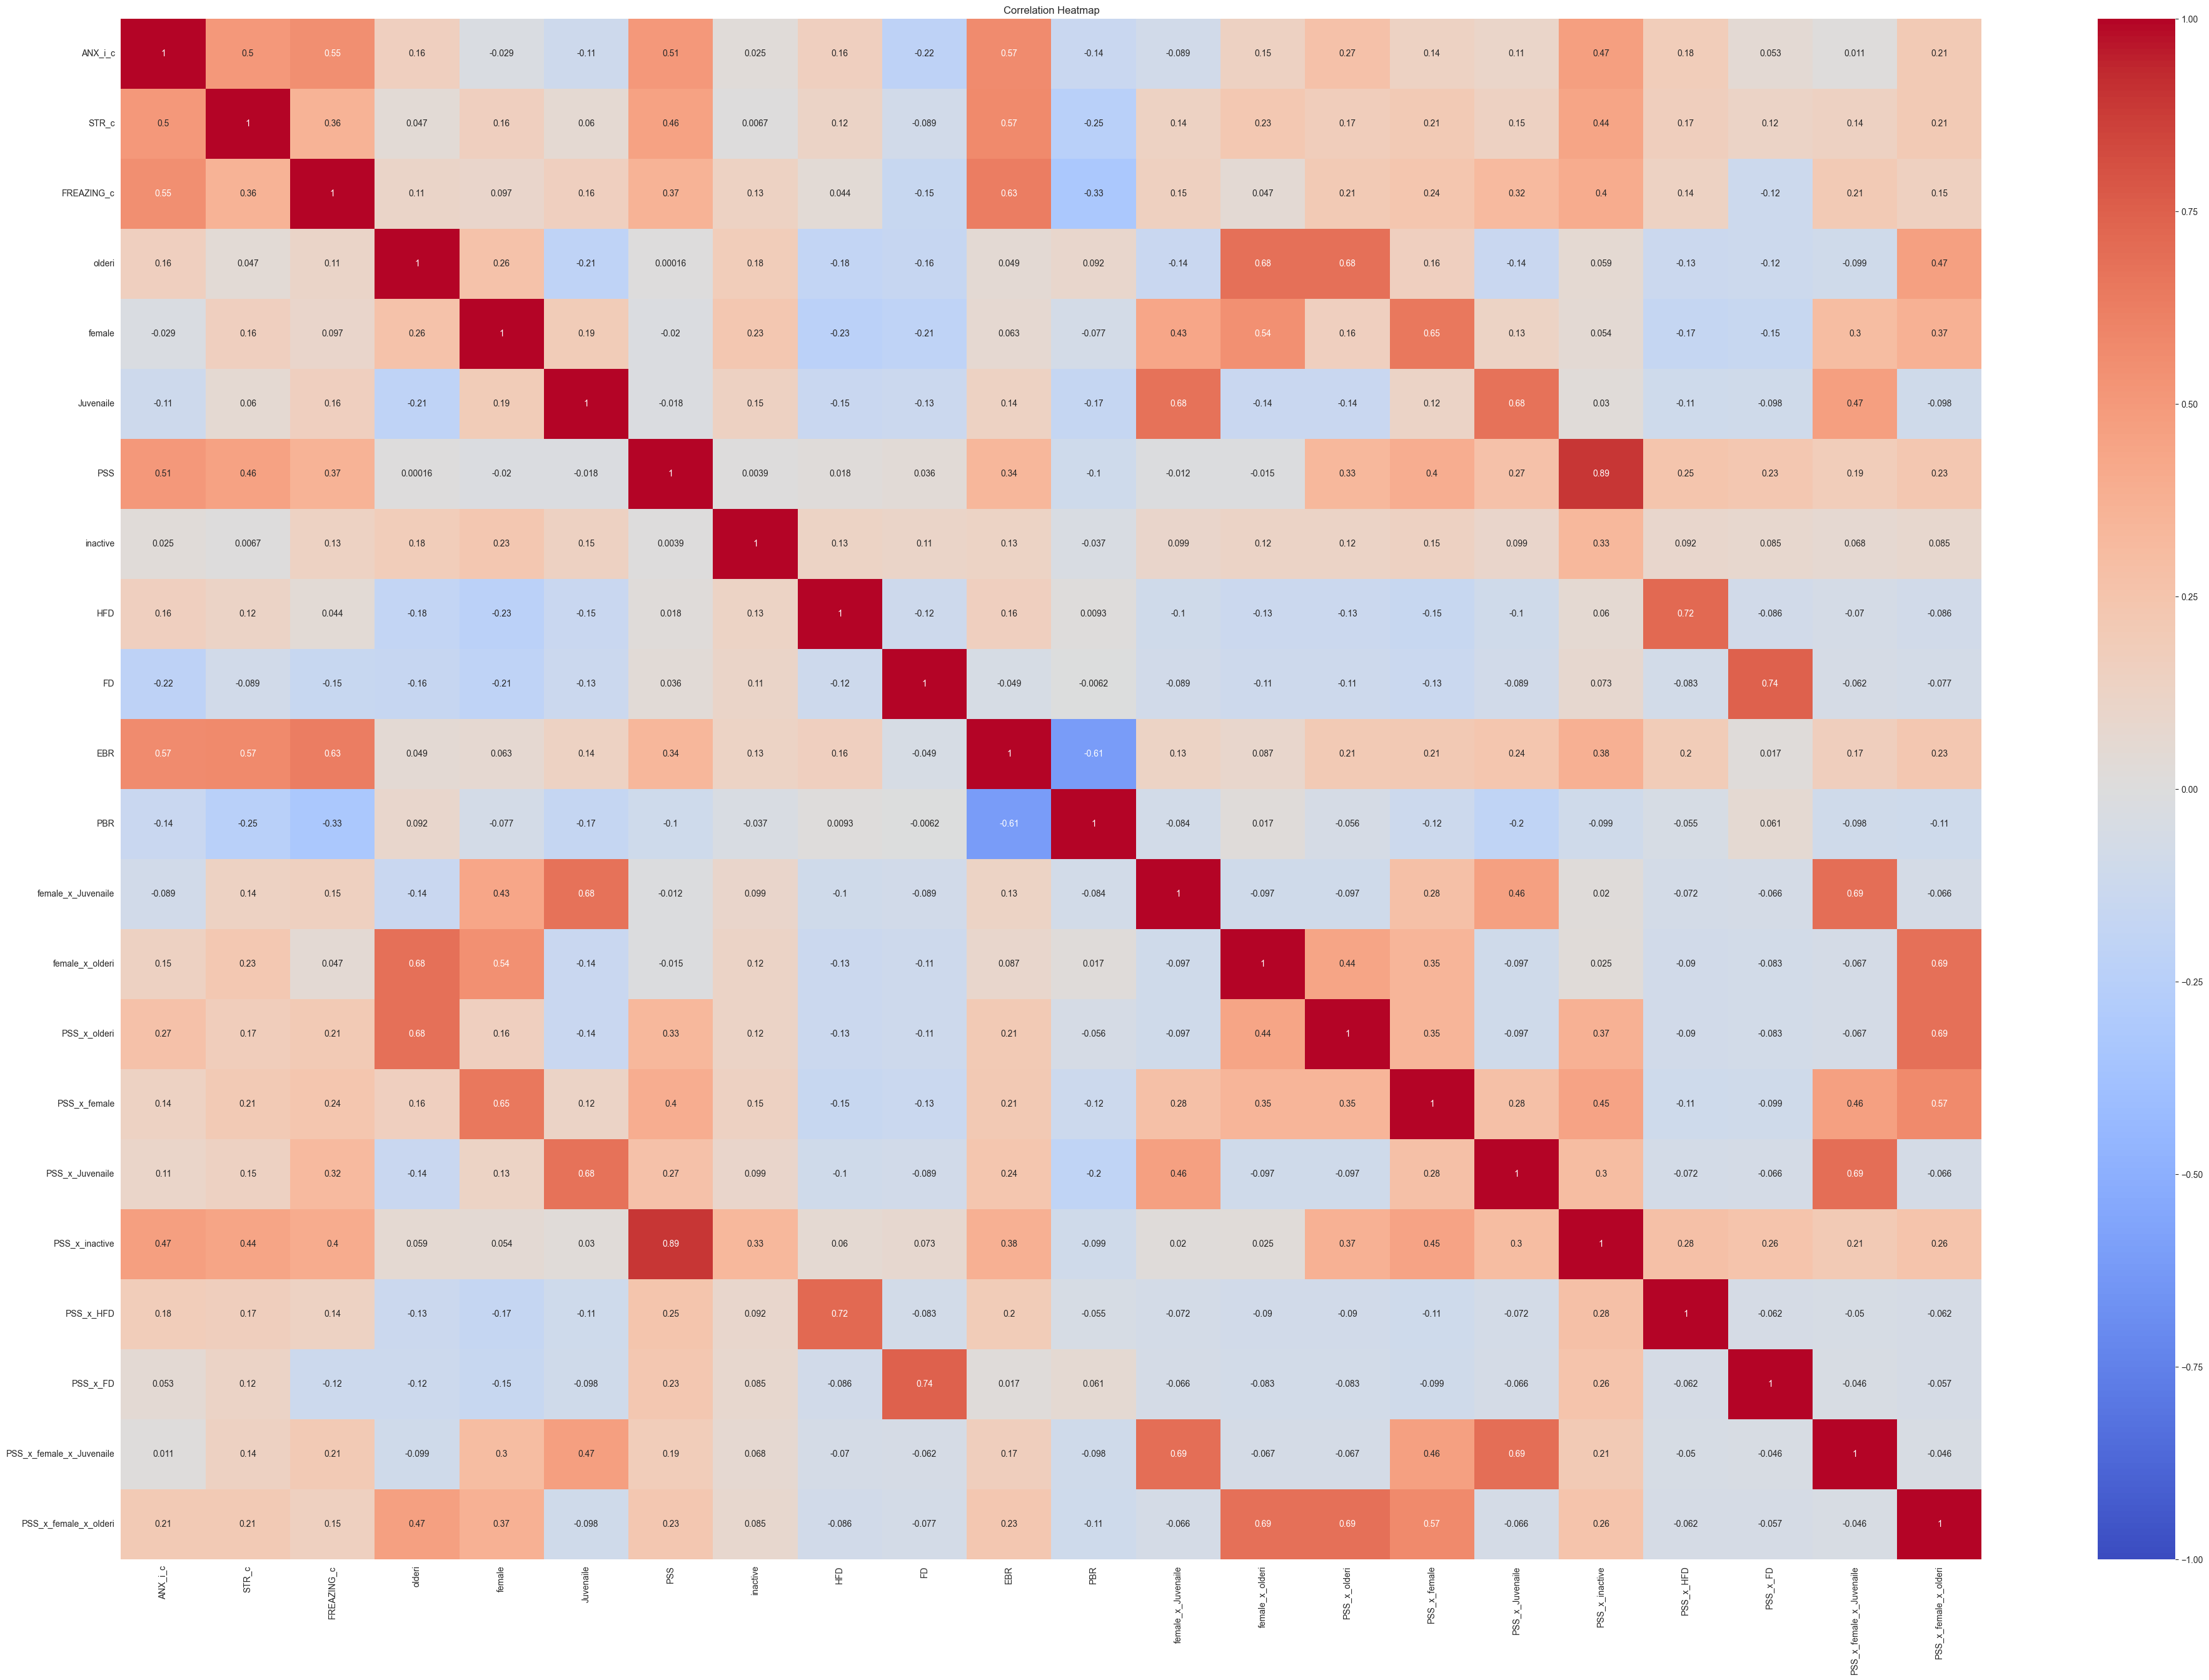


Detailed Correlation Matrix:
                            X                         Y   method alternative  \
0                     ANX_i_c                     STR_c  pearson   two-sided   
1                     ANX_i_c                FREAZING_c  pearson   two-sided   
2                     ANX_i_c                    olderi  pearson   two-sided   
3                     ANX_i_c                    female  pearson   two-sided   
4                     ANX_i_c                 Juvenaile  pearson   two-sided   
..                        ...                       ...      ...         ...   
226                 PSS_x_HFD  PSS_x_female_x_Juvenaile  pearson   two-sided   
227                 PSS_x_HFD     PSS_x_female_x_olderi  pearson   two-sided   
228                  PSS_x_FD  PSS_x_female_x_Juvenaile  pearson   two-sided   
229                  PSS_x_FD     PSS_x_female_x_olderi  pearson   two-sided   
230  PSS_x_female_x_Juvenaile     PSS_x_female_x_olderi  pearson   two-sided   

       n 

In [23]:

# 1. PSS INTERACTIONS
df['PSS_x_olderi']    = df['PSS'] * df['olderi']
df['PSS_x_female']    = df['PSS'] * df['female']
df['PSS_x_Juvenaile']    = df['PSS'] * df['Juvenaile']
df['PSS_x_inactive']    = df['PSS'] * df['inactive']
df['PSS_x_HFD']    = df['PSS'] * df['HFD']
df['PSS_x_FD']    = df['PSS'] * df['FD']
df['PSS_x_female_x_Juvenaile']    = df['PSS'] * df['female_x_Juvenaile']
df['PSS_x_female_x_olderi']    = df['PSS'] * df['female_x_olderi']

# חישוב VIF מחדש אחרי הוספה
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

In [24]:

# =====================================================================
# 3. תיאור מודל SEM
model_desc = """
ANX_i_c      ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi
STR_c        ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi
FREAZING_c   ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 6. ריצה
model, stats = fit_sem(df)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_INT:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_INT:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_INT:
             Chi2  DoF       CFI     RMSEA         AIC         BIC
Value  385.772871  188  0.978265  0.043537  128.612328  409.462267

Parameter Estimates PSS_INT:
          lval  op                      rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~                    olderi -0.007131  0.027982  -0.254835  7.988502e-01
1      ANX_i_c   ~                    female -0.047294  0.026285  -1.799302  7.197087e-02
2      ANX_i_c   ~                 Juvenaile -0.128245  0.030351  -4.225402  2.385151e-05
3      ANX_i_c   ~                  inactive  0.019601  0.026285   0.745703  4.558470e-01
4      ANX_i_c   ~                       HFD  0.071076  0.026585   2.673507  7.506278e-03
5      ANX_i_c   ~                        FD -0.241662  0.029298  -8.248377  2.220446e-16
6      ANX_i_c   ~           female_x_olderi  0.106169  0.041282   2.571810  1.011685e-02
7      ANX_i_c   ~        female_x_Juvenaile  0.121282  0.045527   2.663987  7.722047e-

In [25]:


# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000, random_state=42)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]

print("\nאפקטים ישירים – Bootstrap PSS_1:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_1:")
print(indirect_summary.round(3).to_string())



אפקטים ישירים – Bootstrap PSS_1:
                                       Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                         -0.007  0.027 -0.060  0.048  0.108  -0.268   0.783        False
ANX_i_c ← female                         -0.047  0.030 -0.106  0.013  0.118  -1.554   0.123        False
ANX_i_c ← Juvenaile                      -0.128  0.036 -0.200 -0.061  0.139  -3.587   0.000         True
ANX_i_c ← inactive                        0.020  0.027 -0.033  0.074  0.107   0.730   0.451        False
ANX_i_c ← HFD                             0.071  0.028  0.017  0.126  0.110   2.543   0.012         True
ANX_i_c ← FD                             -0.241  0.035 -0.311 -0.171  0.139  -6.855   0.000         True
ANX_i_c ← female_x_olderi                 0.106  0.041  0.022  0.184  0.162   2.562   0.012         True
ANX_i_c ← female_x_Juvenaile              0.120  0.060  0.005  0.239  0.234   2.005   0.040         True
ANX_i_c ← PSS        

SEM diagram for PSS saved as sem_diagram_pss_INT.png


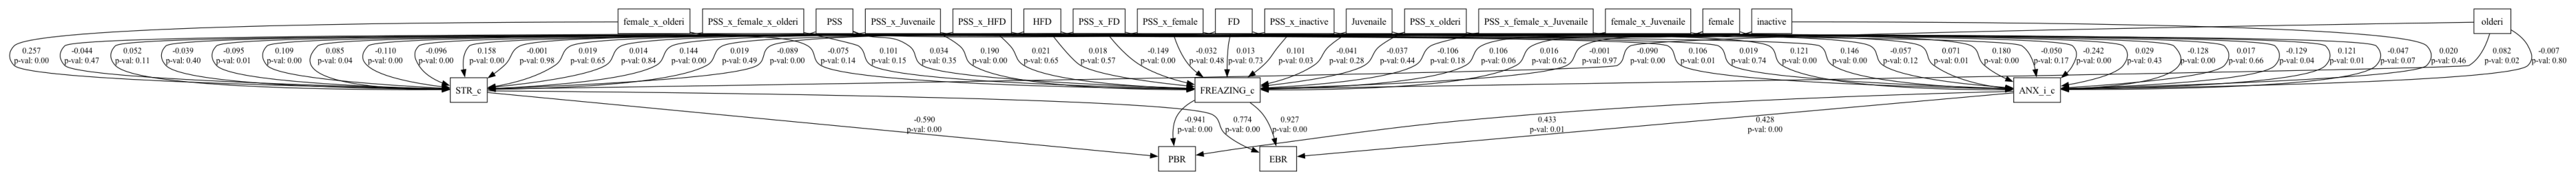

In [29]:

# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_INT.png")
print("SEM diagram for PSS saved as sem_diagram_pss_INT.png")
plt.figure(figsize=(48, 32))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_INT.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

In [27]:

# יצירת גרף
dot = Digraph(comment='SEM Diagram', format='png', engine='dot')

# התאמות כלליות
dot.attr(rankdir='LR', dpi='150', splines='true', nodesep='1', ranksep='40')

# עיצוב ברירת מחדל
dot.attr('node', shape='box', style='filled', fontsize='70', fontname='David', width='12', height='4')

# ------------------
# מיפוי שמות מקוריים -> שמות מוצגים
node_labels = {
    'olderi': 'Old',
    'female': 'Sex (Female)',
    'Juvenaile': 'Juvenile Trauma',
    'inactive': 'Inactive',
    'HFD': 'High Fat Diet',
    'FD': 'Food Deprivation',
    'female_x_olderi': 'Old Female',
    'female_x_Juvenaile': 'Juvenile Trauma Female',
    'PSS': 'PSS',
    'PSS_x_olderi': 'PSS × Old',
    'PSS_x_female': 'PSS × Female',
    'PSS_x_Juvenaile': 'PSS × Juvenile',
    'PSS_x_inactive': 'PSS × Inactive',
    'PSS_x_HFD': 'PSS × HFD',
    'PSS_x_FD': 'PSS × FD',
    'PSS_x_female_x_Juvenaile': 'PSS × Juvenile Trauma Female',
    'PSS_x_female_x_olderi': 'PSS × Old Female ',
    'ANX_i_c': 'Anxiety Index',
    'STR_c': 'Startle Response',
    'FREAZING_c': 'Freezing Behavior',
    'EBR': 'EBR',
    'PBR': 'PBR'
}

# ------------------
# משתנים לפי קבוצות
background_vars = [
    'olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD',
    'female_x_olderi', 'female_x_Juvenaile',
    'PSS', 'PSS_x_olderi', 'PSS_x_female', 'PSS_x_Juvenaile',
    'PSS_x_inactive', 'PSS_x_HFD', 'PSS_x_FD',
    'PSS_x_female_x_Juvenaile', 'PSS_x_female_x_olderi'
]
mediators = ['ANX_i_c', 'STR_c', 'FREAZING_c']
outcomes = ['EBR', 'PBR']

# ------------------
# פונקציה אוטומטית לסידור בקבוצות
def add_nodes_in_group(dot, nodes, color):
    with dot.subgraph() as s:
        s.attr(rank='same')
        for node in nodes:
            label = node_labels.get(node, node)
            s.node(node, label=label, color=color)

# סידור משתנים לפי קבוצה
add_nodes_in_group(dot, background_vars, 'lightblue')
add_nodes_in_group(dot, mediators, 'lightgreen')
add_nodes_in_group(dot, outcomes, 'lightpink')

def estimate_penwidth(beta):
    """
    מחשב את עובי הקו לפי ערך מוחלט של β
    """
    return 1 + abs(beta) * 10 +10  # קו בסיסי בעובי 1, ועולה עם חוזק האפקט

def estimate_style(beta, significance_threshold=0.05):
    """
    מחזיר סגנון קו: קו רציף אם האפקט מובהק, קו מקוקו אם לא
    """
    return 'solid' if abs(beta) < significance_threshold else 'dashed'

def estimate_color(beta, significance_threshold=0.05):
    """
    מחזיר סגנון קו: קו רציף אם האפקט מובהק, קו מקוקו אם לא
    """
    return 'black' if abs(beta) < significance_threshold else 'red'



# שליפת האומדנים
inspect_df = model.inspect()

# נשמור רק את הנתיבים (ולא שונויות, לא קווריאנסים וכו')
edges = inspect_df[inspect_df['op'] == '~'][['lval', 'rval', 'Estimate', 'p-value']]

# יצירת רשימת משתנים
variables = set(edges['lval']).union(set(edges['rval']))
for var in variables:
    dot.node(var.strip())

# הוספת חצים
for _, row in edges.iterrows():
    label = f"{row['Estimate']:.2f}"
    dot.edge(row['rval'].strip(), row['lval'].strip(), label=label,fontsize='90' , penwidth=str(estimate_penwidth(row['Estimate'])),  # עובי בהתאם לגודל β
                 style=estimate_style(row['p-value'] ), color =estimate_color(row['p-value'] ) )             # קו רציף או מקוקו)


# ------------------
# שמירה לקובץ
dot.render('sem_diagram_pss_INT_M', view=True)



'sem_diagram_pss_INT.png'

In [28]:
print (inspect_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lval      65 non-null     object 
 1   op        65 non-null     object 
 2   rval      65 non-null     object 
 3   Estimate  65 non-null     float64
 4   Std. Err  65 non-null     float64
 5   z-value   65 non-null     float64
 6   p-value   65 non-null     float64
dtypes: float64(4), object(3)
memory usage: 3.7+ KB
None
